<a href="https://colab.research.google.com/github/nou321/PFE_Nour/blob/main/Cnn_Testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Partie de prétraitement



## 1- importer les bibliothéques

In [ ]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.backend import dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

## 2- fixer les path des données

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
input_path ='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Anonymized images'
output_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/resized images'
path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Anonymized_images.xlsx'
communResized_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/minCommunResized'
augmented_images='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Augmented_images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3- Redimensionner les images

### Redimensionner les images

In [ ]:
# Liste pour stocker les tailles des images
sizes = []

# Boucle sur les fichiers du dossier
for file_name in os.listdir(input_path):
    if file_name.endswith('.jpg'):
        # Ouverture de l'image
        image = Image.open(os.path.join(input_path, file_name))
        # Ajout de la taille de l'image à la liste
        sizes.append(image.size)


# Trouver la taille minimale dans la liste en termes de surface 
min_size = min(sizes, key=lambda x: x[0]*x[1])
#la taille maximale commun
most_common_size = max(set(sizes), key=sizes.count)
#taille maximale
max_size = max(sizes, key=lambda x: x[0]*x[1])
print(most_common_size)
print(max_size)
print(min_size)


#Boucle sur les fichiers du dossier
for file_name in os.listdir(input_path):
    if file_name.endswith('.jpg'):
        # Ouverture de l'image
        image = Image.open(os.path.join(input_path, file_name))
        # Redimensionnement de l'image à la taille minimale
        image = image.resize(min_size)
        #image.save(os.path.join(communResized_path,file_name))

(921, 641)
(921, 641)
(606, 459)


### explorer les données

Format de l'image: JPEG
Dimensions de l'image: (606, 459)
Mode de l'image: L


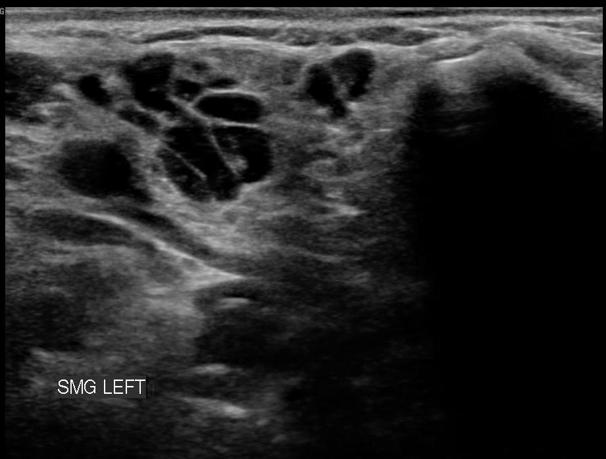

In [ ]:
# Ouvrir l'image
image = Image.open('/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/minCommunResized/001.jpg')

# Afficher les propriétés de l'image
print('Format de l\'image:', image.format)
print('Dimensions de l\'image:', image.size)
print('Mode de l\'image:', image.mode)

# Afficher l'image
image.show()

## 4- les données de classification

In [ ]:
# les index des images sjogreen Vs Non_sjogreen
tab_data = pd.read_excel(path) 
tab_data.head(2)

,Center,Anonymized ID,parotid/submandibular,machine,De Vita et al. score,OMERACT score,Sex,Age at US evaluation,disease duration,fulfillment of 2016 ACR-EULAR classification criteria for pSS
0,Udine (Italy),1,submandibular,samsung,3,3,F,72.0,18,1
1,Udine (Italy),2,parotid,samsung,2,3,F,72.0,18,1


In [ ]:
#rendre les valeurs de colonne : 0 et 1 
y1=tab_data['De Vita et al. score']
y1[y1 != 0] = 1
y1.dtype

<ipython-input-6-1134e1ee8010>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1[y1 != 0] = 1


dtype('int64')

In [ ]:
listz=[]
for element in y1:
  for i in range(4):
      listz.append(element)

z = np.array(listz)

# Optimiser le modéle Cnn

## Mise en Forme des images

In [ ]:
def mise_tenseur (path, nl, nc):
    images_liste = os.listdir(augmented_images)
    images_liste.sort()
    print(images_liste)
    Nb_images = len(images_liste)
    tenseur = np.empty((Nb_images, nl, nc, 1), dtype=np.uint8)
    k = 0
    for im in images_liste:
       
        img = imread(augmented_images+'/'+im)
        tenseur[k, :, :, 0] = img
        k +=1
    return(tenseur)    
#les données sont en ordre
data= mise_tenseur(augmented_images, 459,606)

In [ ]:
data.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2, random_state=42)
# normaliser les données 
x_train = x_train.reshape(x_train.shape[0], 459, 606, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 459, 606, 1).astype('float32') / 255

In [ ]:
model = Sequential()
model.add(Conv2D(128, (11,11), activation='relu', input_shape=(459,606,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.binary_crossentropy
              ,metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
#affichage de fnct loss +accuracy
H1 = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, batch_size=15)

Epoch 1/100
48/48 [==============================] - 17s 358ms/step - loss: 0.6440 - accuracy: 0.6028 - precision: 0.7432 - recall: 0.3627 - val_loss: 0.6919 - val_accuracy: 0.5944 - val_precision: 0.6500 - val_recall: 0.3059
Epoch 2/100
48/48 [==============================] - 18s 366ms/step - loss: 0.6237 - accuracy: 0.6125 - precision: 0.7182 - recall: 0.4213 - val_loss: 0.7264 - val_accuracy: 0.5667 - val_precision: 0.6129 - val_recall: 0.2235
Epoch 3/100
48/48 [==============================] - 18s 372ms/step - loss: 0.6113 - accuracy: 0.6347 - precision: 0.8043 - recall: 0.3947 - val_loss: 0.7263 - val_accuracy: 0.6056 - val_precision: 0.6591 - val_recall: 0.3412
Epoch 4/100
48/48 [==============================] - 17s 365ms/step - loss: 0.5790 - accuracy: 0.6403 - precision: 0.7900 - recall: 0.4213 - val_loss: 0.7247 - val_accuracy: 0.6056 - val_precision: 0.6458 - val_recall: 0.3647
Epoch 5/100
48/48 [==============================] - 17s 360ms/step - loss: 0.5716 - accuracy: 0

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


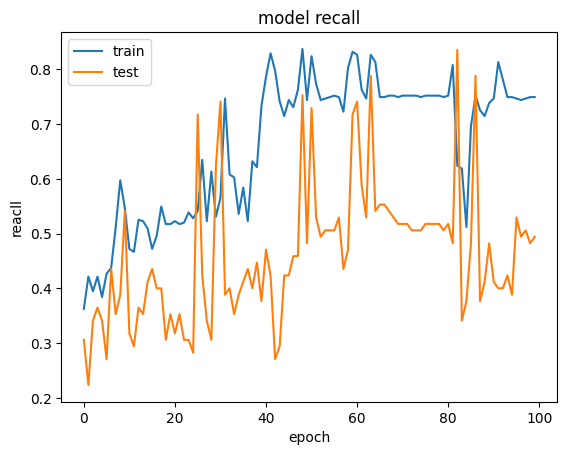

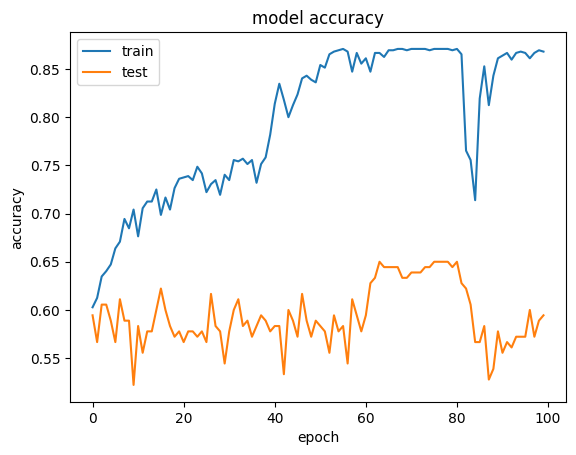

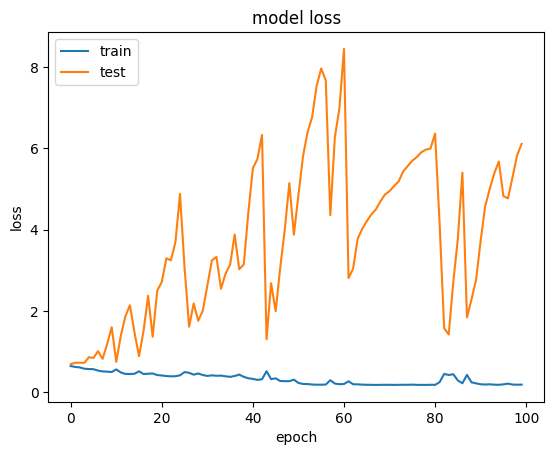

In [ ]:
print(H1.history.keys())
# accuracy
plt.plot(H1.history['recall'])
plt.plot(H1.history['val_recall'])
plt.title('model recall')
plt.ylabel('reacll')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#recall 
# accuracy
plt.plot(H1.history['accuracy'])
plt.plot(H1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(H1.history['loss'])
plt.plot(H1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def mise_tenseur (path, nl, nc):
    images_liste = os.listdir(path)
    images_liste.sort()
    print(images_liste)
    Nb_images = len(images_liste)
    tenseur = np.empty((Nb_images, nl, nc, 1), dtype=np.uint8)
    k = 0
    for im in images_liste:
       
        img = imread(path+'/'+im)
        tenseur[k, :, :, 0] = img
        k +=1
    return(tenseur)    
#les données sont en ordre
data= mise_tenseur(communResized_path, 459,606)

['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg', '011.jpg', '012.jpg', '013.jpg', '014.jpg', '015.jpg', '016.jpg', '017.jpg', '018.jpg', '019.jpg', '020.jpg', '021.jpg', '022.jpg', '023.jpg', '024.jpg', '025.jpg', '026.jpg', '027.jpg', '028.jpg', '029.jpg', '030.jpg', '031.jpg', '032.jpg', '033.jpg', '034.jpg', '035.jpg', '036.jpg', '037.jpg', '038.jpg', '039.jpg', '040.jpg', '041.jpg', '042.jpg', '043.jpg', '044.jpg', '045.jpg', '046.jpg', '047.jpg', '048.jpg', '049.jpg', '050.jpg', '051.jpg', '052.jpg', '053.jpg', '054.jpg', '055.jpg', '056.jpg', '057.jpg', '058.jpg', '059.jpg', '060.jpg', '061.jpg', '062.jpg', '063.jpg', '064.jpg', '065.jpg', '066.jpg', '067.jpg', '068.jpg', '069.jpg', '070.jpg', '071.jpg', '072.jpg', '073.jpg', '074.jpg', '075.jpg', '076.jpg', '077.jpg', '078.jpg', '079.jpg', '080.jpg', '081.jpg', '082.jpg', '083.jpg', '084.jpg', '085.jpg', '086.jpg', '087.jpg', '088.jpg', '089.jpg', '090.jpg', '091.jpg'

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(data, y1, test_size=0.2, random_state=42)
# normaliser les données 
x_train1 = x_train1.reshape(x_train1.shape[0], 459, 606, 1).astype('float32') / 255
x_test1 = x_test1.reshape(x_test1.shape[0], 459, 606, 1).astype('float32') / 255

In [ ]:
model1 = Sequential()
model1.add(Conv2D(128, (11,11), activation='relu', input_shape=(459,606,1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (5,5), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(32, (5,5), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(16, (3,3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(8, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 449, 596, 128)     15616     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 224, 298, 128)    0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 294, 64)      204864    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 147, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 143, 32)      51232     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 71, 32)      

In [ ]:
model1.compile(optimizer='adam',loss=tf.keras.losses.binary_crossentropy
              ,metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
#affichage de fnct loss +accuracy
H2 = model1.fit(x_train1, y_train1, validation_data= (x_test1, y_test1), epochs=200, batch_size=15)

Epoch 1/200
12/12 [==============================] - 8s 400ms/step - loss: 0.6986 - accuracy: 0.4722 - precision_1: 0.4957 - recall_1: 0.6064 - val_loss: 0.6966 - val_accuracy: 0.4667 - val_precision_1: 0.4667 - val_recall_1: 1.0000
Epoch 2/200
12/12 [==============================] - 4s 367ms/step - loss: 0.6967 - accuracy: 0.4889 - precision_1: 0.5122 - recall_1: 0.4468 - val_loss: 0.6924 - val_accuracy: 0.5333 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/200
12/12 [==============================] - 4s 364ms/step - loss: 0.6936 - accuracy: 0.4833 - precision_1: 0.5050 - recall_1: 0.5426 - val_loss: 0.6938 - val_accuracy: 0.4667 - val_precision_1: 0.4667 - val_recall_1: 1.0000
Epoch 4/200
12/12 [==============================] - 4s 359ms/step - loss: 0.6934 - accuracy: 0.5278 - precision_1: 0.5260 - recall_1: 0.9681 - val_loss: 0.6944 - val_accuracy: 0.4667 - val_precision_1: 0.4667 - val_recall_1: 1.0000
Epoch 5/200
12/12 [==============================] - 4s 364m

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])


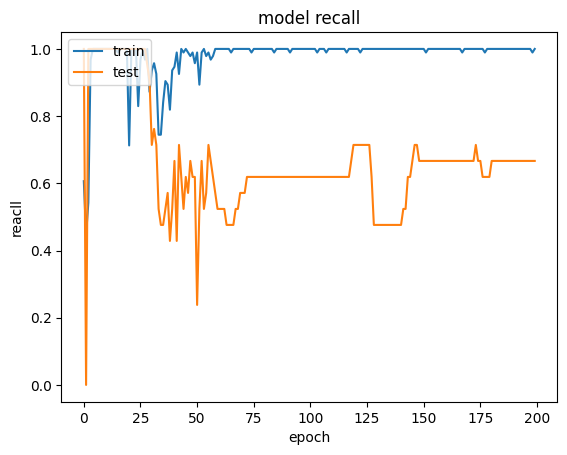

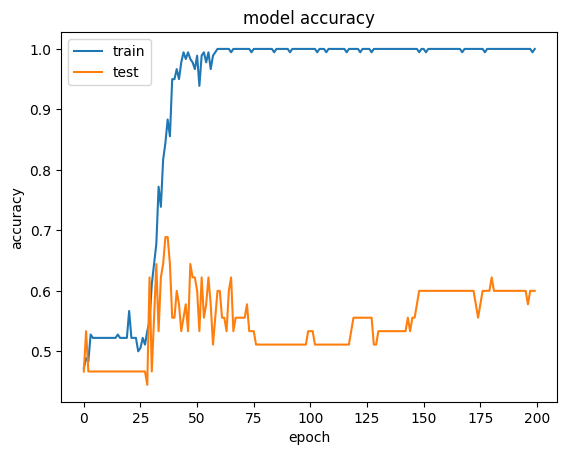

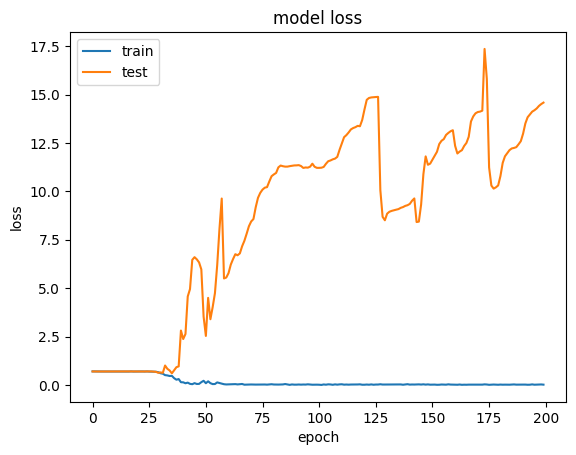

In [ ]:
print(H2.history.keys())
# accuracy
plt.plot(H2.history['recall_1'])
plt.plot(H2.history['val_recall_1'])
plt.title('model recall')
plt.ylabel('reacll')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#recall 
# accuracy
plt.plot(H2.history['accuracy'])
plt.plot(H2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()